In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import joblib
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [16]:
X = pd.read_csv('train_values_transformed/X.csv', sep=',')
y = pd.read_csv('train_values_transformed/y.csv', sep=',')

X = X.drop(columns=['Unnamed: 0'], axis=1)
y = y.drop(columns=['Unnamed: 0'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

In [10]:
print(y.head)

<bound method NDFrame.head of        status_group
0                 3
1                 3
2                 3
3                 1
4                 3
...             ...
59395             3
59396             3
59397             3
59398             3
59399             3

[59400 rows x 1 columns]>


In [17]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

 97%|█████████▋| 30/31 [05:36<00:09,  9.12s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3255
[LightGBM] [Info] Number of data points in the train set: 35640, number of used features: 37
[LightGBM] [Info] Start training from score -0.956511
[LightGBM] [Info] Start training from score -2.621425
[LightGBM] [Info] Start training from score -0.610518


100%|██████████| 31/31 [05:37<00:00, 10.88s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
ExtraTreesClassifier               0.80               0.68    None      0.80   
RandomForestClassifier             0.81               0.68    None      0.80   
BaggingClassifier                  0.78               0.66    None      0.78   
ExtraTreeClassifier                0.74               0.63    None      0.74   
DecisionTreeClassifier             0.74               0.63    None      0.74   
LGBMClassifier                     0.79               0.62    None      0.78   
LabelSpreading                     0.73               0.62    None      0.73   
LabelPropagation                   0.73               0.61    None      0.73   
KNeighborsClassifier               0.75               0.61    None      0.74   
SVC                                0.77               0.57    None      0.74   
AdaBoostClassifier                 0.72 

In [18]:
clf = RandomForestClassifier(max_depth=32, random_state=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f'Model accuracy: {accuracy}')

Model accuracy: 0.8047979797979798


In [3]:
def ApplyGridSearch(classifier, param_grid):
	# Definir el método de división externa (por ejemplo, K-Folds con 5 divisiones)
	outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)

	# Definir el método de división interna para la búsqueda de hiperparámetros
	inner_kf = KFold(n_splits=3, shuffle=True, random_state=42)

	# Realizar la búsqueda de hiperparámetros con validación cruzada anidada
	grid_search = GridSearchCV(classifier, param_grid, cv=inner_kf, verbose=3)

	nested_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_kf)

	# Imprimir los puntajes de rendimiento
	print("Puntajes de validación cruzada anidada:", nested_scores)
	print("Puntaje promedio:", nested_scores.mean())

	# Entrenar el modelo con la búsqueda de hiperparámetros
	grid_search.fit(X_train, y_train)

	return grid_search

In [4]:
def ApplyRandomSearch(classifier, param_dist):
	# Definir el método de división externa (por ejemplo, K-Folds con 5 divisiones)
	outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)

	# Crear un modelo RandomizedSearchCV con el clasificador y el espacio de búsqueda
	random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=20, cv=3, random_state=42, verbose=3)

	# Realizar la búsqueda de hiperparámetros con validación cruzada anidada
	nested_scores = cross_val_score(random_search, X_train, y_train, cv=outer_kf)

	# Imprimir los puntajes de rendimiento
	print("Puntajes de validación cruzada anidada:", nested_scores)
	print("Puntaje promedio:", nested_scores.mean())

	# Entrenar el modelo con la búsqueda de hiperparámetros
	random_search.fit(X_train, y_train)

	return random_search

https://www.kaggle.com/code/sociopath00/random-forest-using-gridsearchcv

In [4]:
param_grid = [
  { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [16, 32],
    'criterion' :['gini', 'entropy']
	}
 ]

grid_search = ApplyGridSearch(RandomForestClassifier(random_state=1), param_grid)

# Acceder al modelo entrenado con los hiperparámetros óptimos
RandomForestClassifier_model_grid_search = grid_search.best_estimator_

y_pred = RandomForestClassifier_model_grid_search.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('---------------------------------')
print(f'Precisión del modelo: {accuracy}')
print(grid_search.best_estimator_)

# CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, y_train)

# y_pred = CV_rfc.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# report = classification_report(y_val, y_pred)

# print('---------------------------------')
# print(f'Precisión del modelo: {accuracy}')

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.786 total time=   3.1s
[CV 2/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.789 total time=   3.1s
[CV 3/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.790 total time=   3.0s
[CV 1/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=200;, score=0.786 total time=   6.1s
[CV 2/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=200;, score=0.788 total time=   6.1s
[CV 3/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=200;, score=0.790 total time=   6.1s
[CV 1/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=300;, score=0.788 total time=   9.2s
[CV 2/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=300;, score=0.789 total time=   9.3s
[CV 3/3] END criterion=gini, max_depth=16,

In [8]:
os.mkdir('output_models')
joblib.dump(RandomForestClassifier_model_grid_search, 'output_models/RandomForestClassifier_model_grid_search.pkl')

['output_models/RandomForestClassifier_model_grid_search.pkl']

In [5]:
param_dist = [
  { 
    'n_estimators': [250, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [16, 32],
    'criterion' :['gini', 'entropy']
	}
 ]

random_search = ApplyRandomSearch(RandomForestClassifier(random_state=1), param_dist)

# Acceder al modelo entrenado con los hiperparámetros óptimos
RandomForestClassifier_model_random_search = random_search.best_estimator_

y_pred = RandomForestClassifier_model_random_search.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

print('---------------------------------')
print(f'Precisión del modelo: {accuracy}')
print(random_search.best_estimator_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=250;, score=0.790 total time=   7.6s
[CV 2/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=250;, score=0.793 total time=   7.6s
[CV 3/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=250;, score=0.787 total time=   7.7s
[CV 1/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=500;, score=0.789 total time=  15.1s
[CV 2/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=500;, score=0.792 total time=  16.0s
[CV 3/3] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=500;, score=0.787 total time=  15.8s
[CV 1/3] END criterion=gini, max_depth=16, max_features=log2, n_estimators=250;, score=0.790 total time=   6.6s
[CV 2/3] END criterion=gini, max_depth=16, max_features=log2, n_estimators=250;, score=0.792 total time=   6.6s
[CV 3/3] END criterion=gini, max_depth=16, 

NameError: name 'grid_search' is not defined

In [6]:
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=32, max_features='log2', n_estimators=500,
                       random_state=1)


In [7]:
joblib.dump(RandomForestClassifier_model_random_search, 'output_models/RandomForestClassifier_model_random_search.pkl')

['output_models/RandomForestClassifier_model_random_search.pkl']

In [9]:
RandomForestClassifier_model_grid_search = joblib.load('output_models/RandomForestClassifier_model_grid_search.pkl')

In [10]:
def ConfusionMatrix(y_pred, labels):
	print(classification_report(y_test, y_pred))
	cm = confusion_matrix(y_test, y_pred, labels=labels)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
	disp.plot()

              precision    recall  f1-score   support

           1       0.39      0.35      0.37      4646
           2       0.09      0.06      0.07       846
           3       0.54      0.61      0.57      6388

    accuracy                           0.47     11880
   macro avg       0.34      0.34      0.34     11880
weighted avg       0.45      0.47      0.46     11880



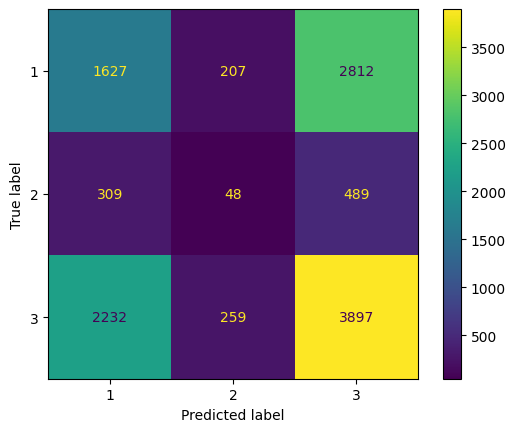

In [12]:
ConfusionMatrix(y_pred, [1, 2, 3])